In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline
sns.color_palette("crest", as_cmap=True)

In [2]:
df_raw = pd.read_csv('data/ca_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

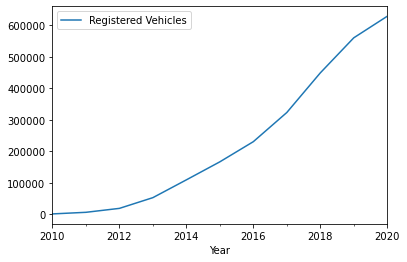

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Registered Vehicles'], ascending = True)
df = df.astype(float)

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()
# df

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

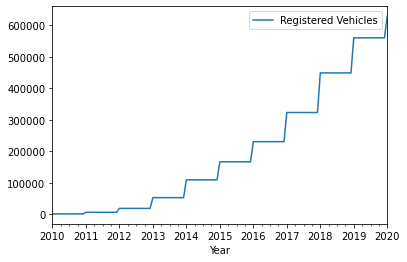

In [7]:
#Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(-1.2631926963710787,
 0.6458390464019452,
 12,
 108,
 {'1%': -3.4924012594942333,
  '5%': -2.8886968193364835,
  '10%': -2.5812552709190673},
 2217.2330623438343)

## Modeling

In [9]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2010':'2018']
test = df['2019':'2020']
combined = df

test

,Registered Vehicles
Year,
2019-01-31,559969.0
2019-02-28,559969.0
2019-03-31,559969.0
2019-04-30,559969.0
2019-05-31,559969.0
2019-06-30,559969.0
2019-07-31,559969.0
2019-08-31,559969.0
2019-09-30,559969.0


In [10]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2956.642, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2886.529, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2439.440, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2438.438, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2440.143, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2440.182, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2441.435, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2440.028, Time=0.12 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.891 seconds
                               SARIMAX Results                                
Dep. Variable:               

### The best model is :  ARIMA (2,0,1) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9971      0.099     20.202      0.000       1.803       2.191
ar.L2         -0.9963      0.102     -9.767      0.000      -1.196      -0.796
ma.L1         -1.0079      0.186     -5.419      0.000      -1.372      -0.643
sigma2      3.321e+08   8.11e-10   4.09e+17      0.000    3.32e+08    3.32e+08


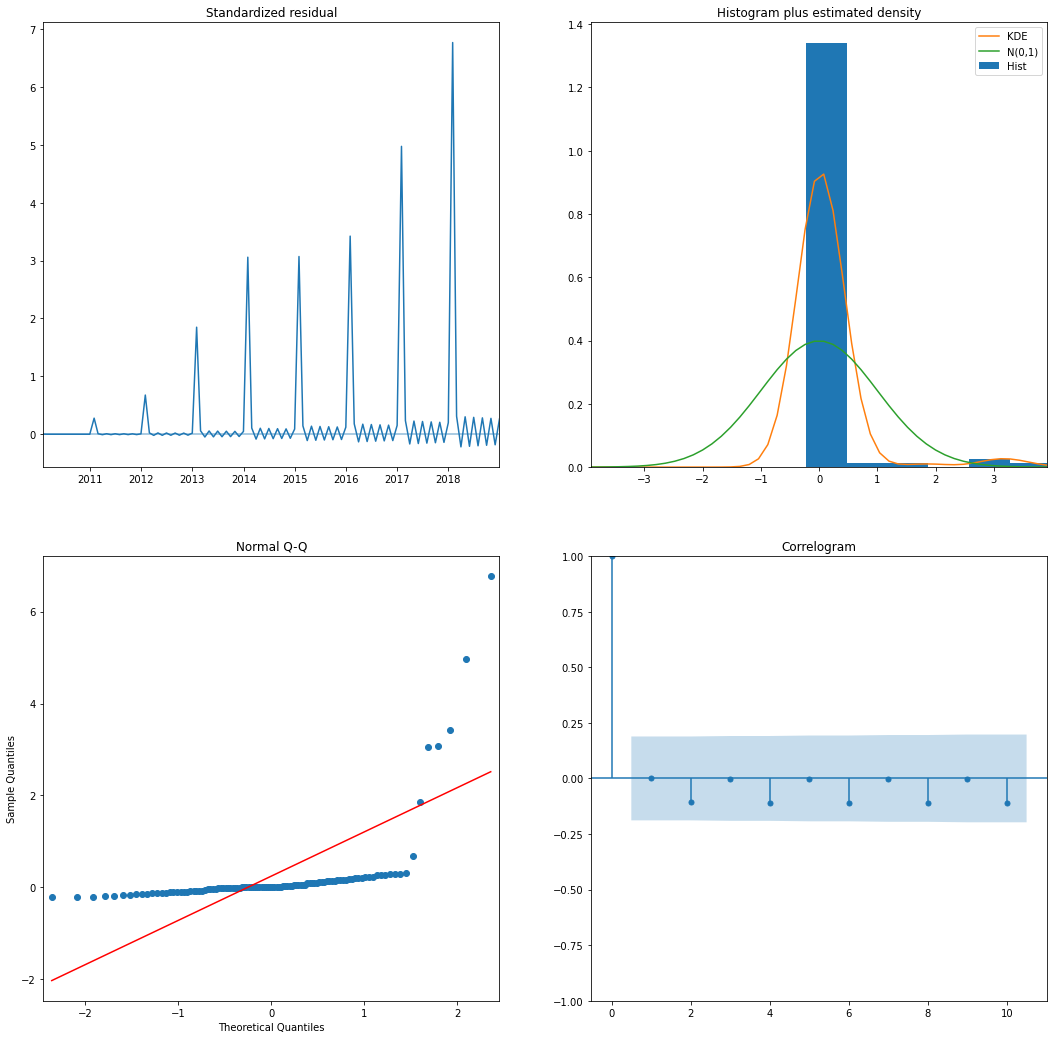

In [11]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [12]:
pred = output.get_prediction(start=pd.to_datetime('2019-01-06'), end=pd.to_datetime('2020-01-05'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2019-01-31,423852.136168,495600.301550
2019-02-28,420509.748816,521879.626926
2019-03-31,420946.353320,545013.663898
2019-04-30,423489.011684,566690.980545
2019-05-31,427491.138979,587574.229157
2019-06-30,432623.001351,608009.658861
2019-07-31,438690.688933,628208.153649
2019-08-31,445569.811127,648311.548342
2019-09-30,453175.868641,668422.268111
2019-10-31,461449.181335,688618.412527


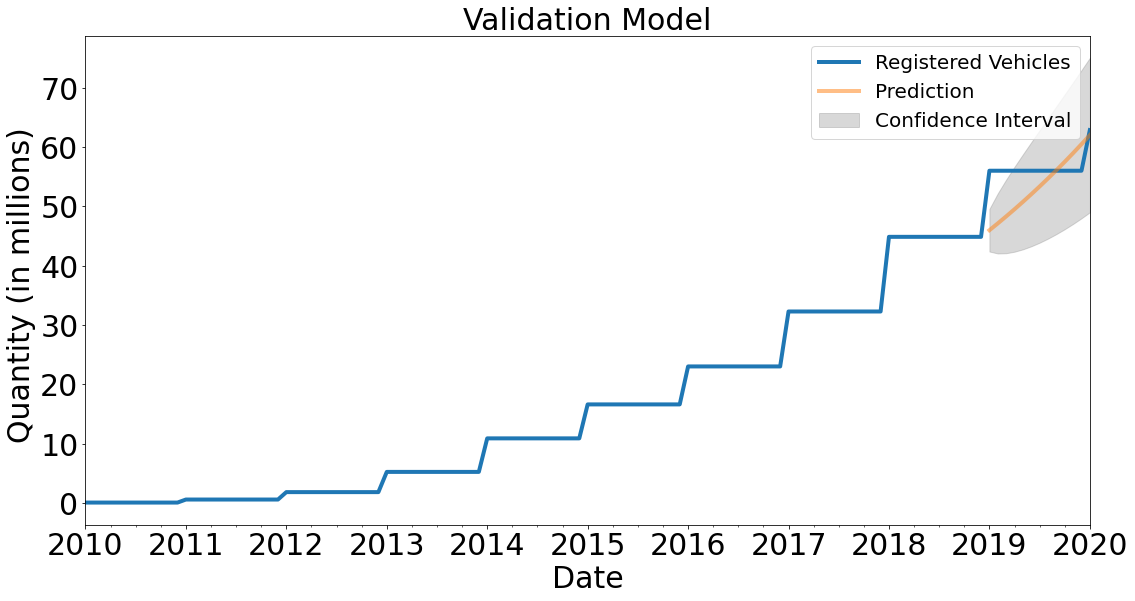

In [16]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in millions) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [14]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9971      0.099     20.202      0.000       1.803       2.191
ar.L2         -0.9963      0.102     -9.767      0.000      -1.196      -0.796
ma.L1         -1.0079      0.186     -5.419      0.000      -1.372      -0.643
sigma2      3.321e+08   8.11e-10   4.09e+17      0.000    3.32e+08    3.32e+08


In [17]:
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2020-02-29,6.024165e+05,6.829437e+05,6.426801e+05
2020-03-31,6.053219e+05,7.090867e+05,6.572043e+05
2020-04-30,6.131943e+05,7.309137e+05,6.720540e+05
2020-05-31,6.234316e+05,7.510434e+05,6.872375e+05
2020-06-30,6.350568e+05,7.704687e+05,7.027627e+05
2020-07-31,6.476134e+05,7.896624e+05,7.186379e+05
2020-08-31,6.608633e+05,8.088790e+05,7.348712e+05
2020-09-30,6.746743e+05,8.282672e+05,7.514708e+05
2020-10-31,6.889702e+05,8.479199e+05,7.684451e+05
2020-11-30,7.037070e+05,8.678982e+05,7.858026e+05


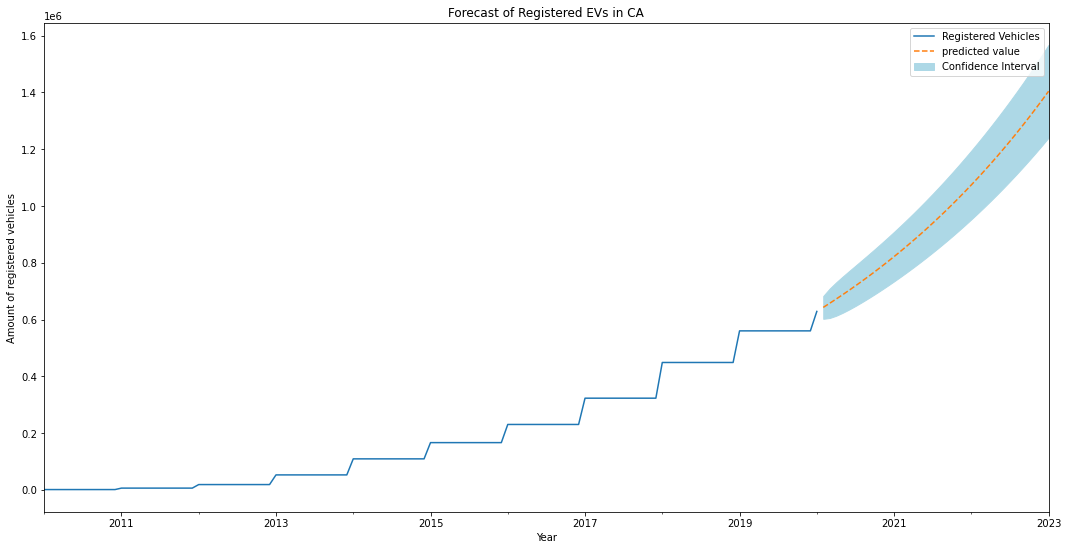

In [19]:
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Observed')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightblue',
                label='Confidence Interval')
scale_y = 1e4
ax.legend() 
plt.ylabel("Amount of registered vehicles")
plt.title('Forecast of Registered EVs in CA')
plt.show()